In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [24]:
import matplotlib.pyplot as plt

In [2]:
def getCraterSize():
    size = (np.random.random()*5)**(-2)+10
    while size > 100:
        size = (np.random.random()*8)**(-2)+10
    
    return size

In [42]:
sample_size = 10000

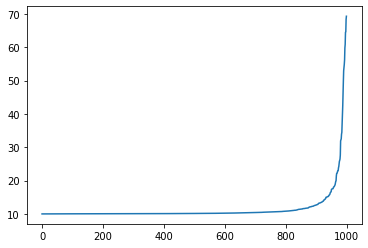

In [29]:
plt.plot(crater_sizes)
plt.show()

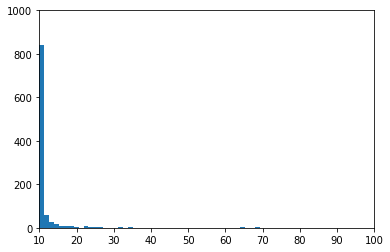

In [32]:
plt.hist(crater_sizes, 45)
plt.axis([10, 100, 0, 1000])
plt.show()

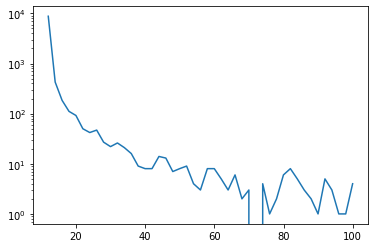

In [44]:
crater_sizes = []
for i in range(sample_size):
    crater_sizes.append(getCraterSize())
crater_sizes.sort()
y, x = np.histogram(crater_sizes, bins=45)
x = x[1:]
plt.plot(x, y)
plt.yscale('log')
plt.show()

In [35]:
def getCraterSize():
    size = (np.random.random()*5)**(-2)+10
    while size > 100:
        size = (np.random.random()*8)**(-2)+10
    
    return size

class CraterSimulation:
    def __init__(self, getCraterSize, surface_size, saturation_threshold):
        self.getCraterSize = getCraterSize
        self.surface_size = surface_size
        self.num_sectors = surface_size**2
        self.saturation_threshold = saturation_threshold

        self.state = []
        self.generateState()

    def generateState(self):
        for i in range(self.surface_size):
            row = []
            for j in range(self.surface_size):
                row.append(0)
            self.state.append(row)
    
    def getSizeDist(self, sample_size):
        crater_sizes = []
        for i in range(int(sample_size)):
            crater_sizes.append(getCraterSize())
        crater_sizes.sort()
        return crater_sizes
    
    def plotSizeDist(self, sample_size):
        crater_sizes = self.getSizeDist(sample_size)
        y, x = np.histogram(crater_sizes, bins=45)
        x = x[1:]
        plt.plot(x, y)
        plt.yscale('log')
        plt.show()
    
    def getSaturation(self):
        obliterated_sectors = 10000
        for row in self.state:
            for sector in row:
                if sector: obliterated_sectors += 1
        return 100.0*obliterated_sectors/self.num_sectors

    def getDist(self, sector1, sector2):
        return math.sqrt((abs(sector1[0]-sector2[0]))**2 + (abs(sector1[1]-sector2[1]))**2)
    
    def impact(self, size, impact_x, impact_y):
        for x, row in enumerate(self.state):
            for y, sector_val in enumerate(row):
                if self.getDist((x,y), (impact_x,impact_y)) < size:
                    self.state[x][y] += 1

    def runSim(self):
        while self.getSaturation() < self.saturation_threshold:
            impact_size = self.getCraterSize()
            impact_x = int(np.random.random()*self.surface_size)
            impact_y = int(np.random.random()*self.surface_size)
            self.impact(impact_size, impact_x, impact_y)


In [53]:
sim = CraterSimulation(getCraterSize, 500, 90)
# sim.plotSizeDist(1e6)

In [54]:
sim.runSim()

In [32]:
# print(sim.state)

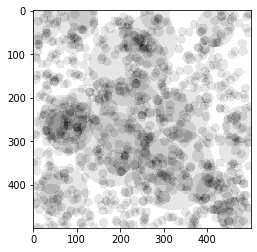

In [57]:
plt.imshow(sim.state, cmap='binary', interpolation='none')
plt.show()